In [45]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import ipywidgets as widgets
from IPython.display import display
# The NEAT-Python library imports
import modneat
from modneat import visualize
# import task
current_dir = str(Path().resolve())
sys.path.append(os.path.join(current_dir, '..'))
import settings.task as task

#load experiment settings
setting_path = "../settings/command"
with open(setting_path) as f:
    settings = f.read()
matches=re.findall(r'(\w+)=(\S+)', settings) #キーと値のペアを取得
tmp_dict = {key: value for key, value in matches}
# dict itemのうち、"'something'" のような文字列を 'something' に変換
experiment_settings = {}
for key, value in tmp_dict.items():
    after = re.findall(r'["\'](.*?)["\']', value)
    print(after)
    if(len(after) == 0):
        experiment_settings[key] = value
    else:
        experiment_settings[key] = after[0]
print('### settings:',experiment_settings)

#load checkpoint
checkpoints_path = '../checkpoints/'
checkpoints = os.listdir(checkpoints_path)
sorted_checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[1]))

# 選択メニュー用のウィジェットを作成
dropdown = widgets.Dropdown(
    options=sorted_checkpoints,  # リストから選択肢を指定
    description='Select a checkpoint:',
    disabled=False,
)

global selected_checkpoint
selected_checkpoint = sorted_checkpoints[0]

# 選択メニューの値が変更されたときに実行される関数
def on_change(change):
    global selected_checkpoint
    if change['type'] == 'change' and change['name'] == 'value':
        selected_checkpoint = change['new']
        print(f"Selected checkpoint: {selected_checkpoint}")

# 選択メニューの値が変更されたときに on_change 関数を呼び出す
dropdown.observe(on_change)

# ウィジェットを表示
display(dropdown)

[]
['']
['./configs/modexhebb_genome.ini']
['rate_of_changeが-0.3~0.3の設定.二次学習的な興味深い個体が生じる？']
[]
['ModExHebbFFN']
[]
[]
['./results']
['test_learning']
### settings: {'checkpoint_interval': '10', 'checkpoint_load': '', 'config': './configs/modexhebb_genome.ini', 'description': 'rate_of_changeが-0.3~0.3の設定.二次学習的な興味深い個体が生じる？', 'generation': '1000', 'network': 'ModExHebbFFN', 'num_workers': '0', 'run_id': '201', 'savedir': './results', 'task': 'test_learning'}


Dropdown(description='Select a checkpoint:', options=('checkpoint-9', 'checkpoint-19', 'checkpoint-29', 'check…

Selected checkpoint: checkpoint-59


In [46]:
print(experiment_settings)
print(selected_checkpoint)

{'checkpoint_interval': '10', 'checkpoint_load': '', 'config': './configs/modexhebb_genome.ini', 'description': 'rate_of_changeが-0.3~0.3の設定.二次学習的な興味深い個体が生じる？', 'generation': '1000', 'network': 'ModExHebbFFN', 'num_workers': '0', 'run_id': '201', 'savedir': './results', 'task': 'test_learning'}
checkpoint-59


In [50]:
p = modneat.Checkpointer.restore_checkpoint(os.path.join('../checkpoints', selected_checkpoint))
task_name = experiment_settings['task']
print(task_name)
t = eval('task' + task_name)

test_learning


AttributeError: module 'settings.task' has no attribute 'eval'

In [2]:
p = modneat.Checkpointer.restore_checkpoint('../results/task.non_static_ModIndExHebbFFN_0/checkpoints/checkpoint-99')
t = task.non_static(network_type = modneat.nn.ModIndExHebbFFN)

In [3]:
best_genome = p.run(t.eval_genomes, 1)

net = modneat.nn.ModIndExHebbFFN.create(best_genome, p.config)
fitness, log = t.eval_fitness(net, history_log = True)

Mean genetic distance 2.467, standard deviation 0.671
*** [WARNING] FileOutputReporter couldn't find a savepath ./results/task.non_static_ModIndExHebbFFN_0/results.txt
*** 5


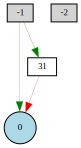

In [4]:
modneat.visualize.draw_net(p.config, best_genome, show_disabled=False)

<AxesSubplot:xlabel='node_id', ylabel='step'>

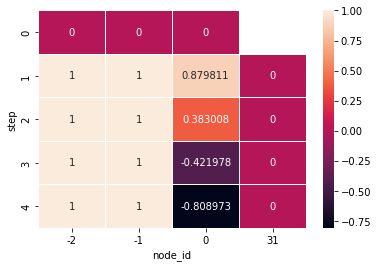

In [8]:
#各ノードの活性化値の可視化

cols = ['step', 'node_id', 'values']
df = pd.DataFrame(index=[], columns = cols)


hist = [items['values'] for items in log]

step = 0
for values in hist:
    
    for i in values.items():
        record = pd.Series([step, i[0], i[1]], index=df.columns)
        df = df.append(record, ignore_index=True)
    step += 1

df['step'] = df['step'].astype(int)
df['node_id'] = df['node_id'].astype(int)

df_pivot = pd.pivot_table(data = df, values='values', columns='node_id', index='step')
sns.heatmap(df_pivot, annot=True, fmt='g', linewidth=.5)

<AxesSubplot:xlabel='node_id', ylabel='step'>

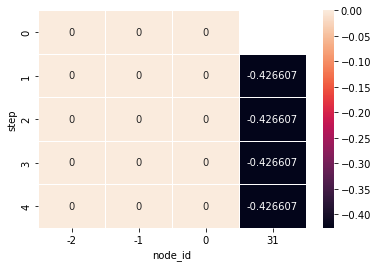

In [13]:
#各ノードの修飾値の可視化

cols = ['step', 'node_id', 'mod_values']
df = pd.DataFrame(index=[], columns = cols)


hist = [items['modulate_values'] for items in log]

step = 0
for values in hist:
    
    for i in values.items():
        record = pd.Series([step, i[0], i[1]], index=df.columns)
        df = df.append(record, ignore_index=True)
    step += 1

df['step'] = df['step'].astype(int)
df['node_id'] = df['node_id'].astype(int)

df_pivot = pd.pivot_table(data = df, values='mod_values', columns='node_id', index='step')
sns.heatmap(df_pivot, annot=True, fmt='g', linewidth=.5)

(0, False, <function tanh_activation at 0x149ee8fcd8b0>, <function sum_aggregation at 0x149ee8fdf670>, 0.15480495011652473, 1.0, [(-1, 0.3951674859478872, -1.0169724736659658, 0.6825787453326092, 0.05307229065281457, -1.8365590031083825), (31, -0.4383567111498524, 0.729802350141939, -0.17160467372764537, 0.9500288761148634, 0.2559165046710232)])


<AxesSubplot:xlabel='connection', ylabel='step'>

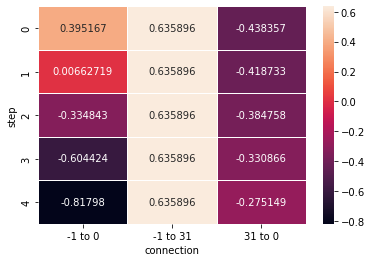

In [16]:
### 重みの変化を表示

cols = ['step', 'connection', 'weight']
df = pd.DataFrame(index=[], columns = cols)


node_evals = [items['node_evals'] for items in log]

print(node_evals[0][1])

step = 0
for node_eval in node_evals:
    
    for n in range(len(node_eval)):
    
        for each_connection_info in node_eval[n][-1]:
            record = pd.Series([step, str(each_connection_info[0]) + ' to ' + str(node_eval[n][0]), each_connection_info[1]], index=df.columns)
            df = df.append(record, ignore_index=True)
    step += 1

df['step'] = df['step'].astype(int)
#df['connection'] = df['connection'].astype(int)

df_pivot = pd.pivot_table(data = df, values='weight', columns='connection', index='step')
sns.heatmap(df_pivot, annot=True, fmt='g', linewidth=.5)